### Charity Donation & Fund Utilization Tracker

**Database:** Donors, donations, causes, utilization logs.  

**Features:**
1. Donation source analysis.  
2. Fund allocation per cause.  
3. Donor retention.  
4. **Graphs:** Pie chart (funds by cause), bar chart (monthly donations), line chart (growth of donations).  

In [1]:
# --- Cell 1: Imports & Database Setup ---
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Create / connect to SQLite database
DB = "charity_tracker.db"
conn = sqlite3.connect(DB)
cur = conn.cursor()

In [2]:
# --- Cell 2: Create Tables ---
# Define schema for donors, causes, donations, and utilization tables
schema = """
DROP TABLE IF EXISTS utilization;
DROP TABLE IF EXISTS donations;
DROP TABLE IF EXISTS donors;
DROP TABLE IF EXISTS causes;

CREATE TABLE donors (
    donor_id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    email TEXT
);

CREATE TABLE causes (
    cause_id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    description TEXT
);

CREATE TABLE donations (
    donation_id INTEGER PRIMARY KEY,
    donor_id INTEGER NOT NULL,
    cause_id INTEGER NOT NULL,
    amount INTEGER NOT NULL,
    date DATE NOT NULL,
    FOREIGN KEY (donor_id) REFERENCES donors(donor_id),
    FOREIGN KEY (cause_id) REFERENCES causes(cause_id)
);

CREATE TABLE utilization (
    utilization_id INTEGER PRIMARY KEY,
    cause_id INTEGER NOT NULL,
    amount_spent INTEGER NOT NULL,
    date DATE NOT NULL,
    notes TEXT,
    FOREIGN KEY (cause_id) REFERENCES causes(cause_id)
);
"""

cur.executescript(schema)
conn.commit()

In [3]:
# --- Cell 3: Insert Dummy Data ---
# Add donors (10 Indian cricketers), causes, donations, and utilization logs

# Donors
donors = [
    ("Virat Kohli", "virat@example.com"),
    ("Rohit Sharma", "rohit@example.com"),
    ("MS Dhoni", "dhoni@example.com"),
    ("Sachin Tendulkar", "sachin@example.com"),
    ("Yuvraj Singh", "yuvraj@example.com"),
    ("Rahul Dravid", "dravid@example.com"),
    ("Sourav Ganguly", "ganguly@example.com"),
    ("Kapil Dev", "kapil@example.com"),
    ("Hardik Pandya", "hardik@example.com"),
    ("Jasprit Bumrah", "bumrah@example.com")
]
cur.executemany("INSERT INTO donors(name, email) VALUES (?, ?)", donors)

# Causes
causes = [
    ("Education", "Scholarships for underprivileged children"),
    ("Healthcare", "Medical aid & hospitals"),
    ("Disaster Relief", "Emergency fund for natural disasters"),
    ("Sports", "Training for young athletes"),
    ("Environment", "Tree plantation & clean-up drives")
]
cur.executemany("INSERT INTO causes(name, description) VALUES (?, ?)", causes)

# Donations (static values between 1L - 1Cr)
donations = [
    (1, 1, 5000000, "2024-01-10"),
    (2, 2, 10000000, "2024-02-15"),
    (3, 3, 2000000, "2024-03-20"),
    (4, 4, 7500000, "2024-01-25"),
    (5, 5, 3000000, "2024-04-05"),
    (6, 6, 1500000, "2024-05-10"),
    (7, 7, 4000000, "2024-06-01"),
    (8, 8, 2500000, "2024-06-15"),
    (9, 9, 6000000, "2024-07-01"),
    (10, 10, 1000000, "2024-07-20")
]
cur.executemany("INSERT INTO donations(donor_id, cause_id, amount, date) VALUES (?, ?, ?, ?)", donations)

# Utilization logs
utilization = [
    (1, 2000000, "2024-02-01", "Paid scholarships for 200 students"),
    (2, 5000000, "2024-03-01", "Hospital equipment purchase"),
    (3, 1500000, "2024-04-15", "Athlete coaching programs"),
    (4, 3000000, "2024-05-01", "Flood relief camps"),
    (5, 1000000, "2024-06-10", "Tree plantation in Mumbai")
]
cur.executemany("INSERT INTO utilization(cause_id, amount_spent, date, notes) VALUES (?, ?, ?, ?)", utilization)

conn.commit()

              donor  total_donated
0      Rohit Sharma       10000000
1  Sachin Tendulkar        7500000
2     Hardik Pandya        6000000
3       Virat Kohli        5000000
4    Sourav Ganguly        4000000
5      Yuvraj Singh        3000000
6         Kapil Dev        2500000
7          MS Dhoni        2000000
8      Rahul Dravid        1500000
9    Jasprit Bumrah        1000000


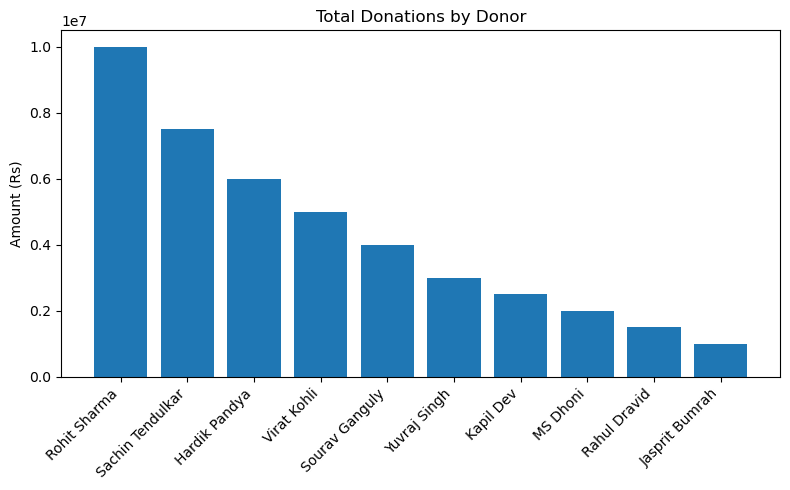

In [4]:
# --- Cell 4: Donation Source Analysis ---
# Find total donations per donor and show a bar chart

donor_analysis = pd.read_sql_query("""
SELECT d.name AS donor, SUM(o.amount) AS total_donated
FROM donations o
JOIN donors d ON o.donor_id = d.donor_id
GROUP BY o.donor_id
ORDER BY total_donated DESC;
""", conn)

print(donor_analysis)

plt.figure(figsize=(8,5))
plt.bar(donor_analysis["donor"], donor_analysis["total_donated"])
plt.xticks(rotation=45, ha="right")
plt.title("Total Donations by Donor")
plt.ylabel("Amount (Rs)")
plt.tight_layout()
plt.show()

             cause  total_donations
0        Education          5000000
1       Healthcare         10000000
2  Disaster Relief          2000000
3           Sports          7500000
4      Environment          3000000


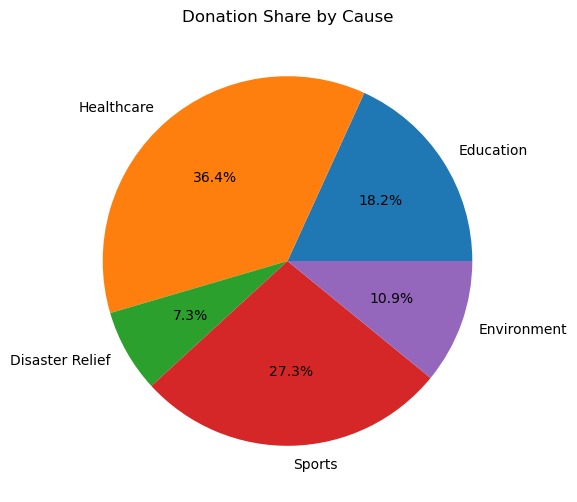

In [5]:
# --- Cell 5: Fund Allocation per Cause ---
# Analyze donations per cause and display as pie chart

cause_funds = pd.read_sql_query("""
SELECT c.name AS cause, SUM(o.amount) AS total_donations
FROM donations o
JOIN causes c ON o.cause_id = c.cause_id
GROUP BY c.cause_id;
""", conn)

print(cause_funds)

plt.figure(figsize=(6,6))
plt.pie(cause_funds["total_donations"], labels=cause_funds["cause"], autopct="%1.1f%%")
plt.title("Donation Share by Cause")
plt.show()

In [6]:
# --- Cell 6: Donor Retention ---
# Find donors who donated multiple times (retention analysis)

donor_retention = pd.read_sql_query("""
SELECT d.name AS donor, COUNT(o.donation_id) AS donation_count
FROM donations o
JOIN donors d ON o.donor_id = d.donor_id
GROUP BY o.donor_id
HAVING donation_count > 1;
""", conn)

if donor_retention.empty:
    print("Currently, all donors donated only once. (Retention not applicable)")
else:
    print(donor_retention)

Currently, all donors donated only once. (Retention not applicable)


     month     total
0  2024-01  12500000
1  2024-02  10000000
2  2024-03   2000000
3  2024-04   3000000
4  2024-05   1500000
5  2024-06   6500000
6  2024-07   7000000


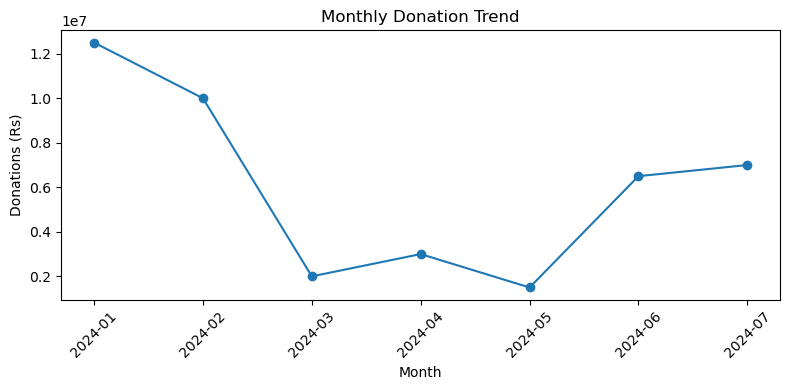

In [7]:
# --- Cell 7: Monthly Donations Trend ---
# Analyze total donations per month and plot as line chart

monthly_donations = pd.read_sql_query("""
SELECT strftime('%Y-%m', date) AS month, SUM(amount) AS total
FROM donations
GROUP BY month
ORDER BY month;
""", conn)

print(monthly_donations)

plt.figure(figsize=(8,4))
plt.plot(monthly_donations["month"], monthly_donations["total"], marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Donation Trend")
plt.xlabel("Month")
plt.ylabel("Donations (Rs)")
plt.tight_layout()
plt.show()

         date  cumulative_donations
0  2024-01-10               5000000
1  2024-01-25              12500000
2  2024-02-15              22500000
3  2024-03-20              24500000
4  2024-04-05              27500000
5  2024-05-10              29000000
6  2024-06-01              33000000
7  2024-06-15              35500000
8  2024-07-01              41500000
9  2024-07-20              42500000


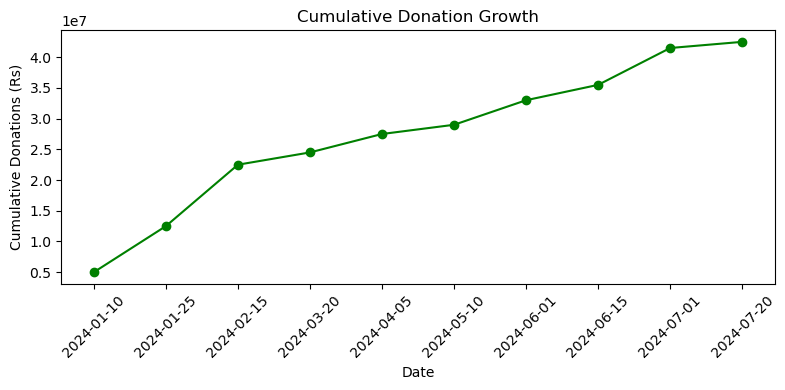

In [8]:
# --- Cell 8: Donation Growth Over Time ---
# Calculate cumulative donations and plot growth

growth = pd.read_sql_query("""
SELECT date, SUM(amount) OVER (ORDER BY date) AS cumulative_donations
FROM donations
ORDER BY date;
""", conn)

print(growth)

plt.figure(figsize=(8,4))
plt.plot(growth["date"], growth["cumulative_donations"], marker="o", color="green")
plt.xticks(rotation=45)
plt.title("Cumulative Donation Growth")
plt.xlabel("Date")
plt.ylabel("Cumulative Donations (Rs)")
plt.tight_layout()
plt.show()

In [9]:
# --- Cell 9: Close DB Connection ---
conn.close()